In [1]:
import torch
import os
import numpy as np
from time import time
import pandas as pd
from glob import glob

torch.cuda.set_device(1)
_seed=12 #7,34,12
torch.manual_seed(_seed)     
torch.cuda.manual_seed(_seed)   
torch.cuda.manual_seed_all(_seed)  
np.random.seed(_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

AFFilesRoot = r'.\Seg'
AFFiles = glob(AFFilesRoot+'\*.npy*')

AFFiles.sort()

#Select the wanted files
#files=...
#split Training and Testing set

subjects = list(pd.Series(list([sub.split('_')[-2] for sub in AFFiles])).drop_duplicates())
test_size = 0.1

np.random.shuffle(subjects)
test_sub = subjects[0:int(len(subjects)*test_size)]
train_sub = subjects[int(len(subjects)*test_size)::]

AFtest = [file for file in AFFiles if (file.split('_')[-2] in test_sub and file.split('_')[-3][-1] in ['N','A'])]
AFtrain = [file for file in AFFiles if (file.split('_')[-2] in train_sub and file.split('_')[-3][-1] in ['N','A'])]


print(len(AFtrain), len(AFtest), len(AFFiles),len(train_sub),len(test_sub))


''' See the sample distribution
l=pd.Series([f.split('_')[-2][-1] for f in AFfiles])
print(l.value_counts())
len(AFfiles)
for f in AFfiles:
    if f.split('/')[-1].split('_')[0] not in ['N','O','A','~']:
        #print (f)
        pass
print('***')
tmp = [f for f in AFfiles if f.split('_')[-2][-1] in ['N','O','A','~']]
l=pd.Series([f.split('_')[-2][-1] for f in tmp])
print(l.value_counts())
'''


50474 5612 82888 7676 852
Wall time: 7.73 s


" See the sample distribution\nl=pd.Series([f.split('_')[-2][-1] for f in AFfiles])\nprint(l.value_counts())\nlen(AFfiles)\nfor f in AFfiles:\n    if f.split('/')[-1].split('_')[0] not in ['N','O','A','~']:\n        #print (f)\n        pass\nprint('***')\ntmp = [f for f in AFfiles if f.split('_')[-2][-1] in ['N','O','A','~']]\nl=pd.Series([f.split('_')[-2][-1] for f in tmp])\nprint(l.value_counts())\n"

In [27]:
import torch
from torch.utils import data
from torchvision import transforms as T
from PIL import Image, ImageFilter
import scipy.io
from scipy import signal
import random

AFLabel = {'N': 0,
           'A': 1,
           'O': 2,
           '~': 3}

class PhysionetChallenge2017_1Da(data.Dataset): # Temp
    def __init__(self, filelist, istrain=True, transforms = None):
        # Get the filelist and img data
        self.filelist = filelist
        self.istrain = istrain

    def __getitem__(self, index):
        # _A00004_0.mat
        file_path = self.filelist[index]
        self.label = AFLabel.__getitem__(file_path.split('_')[-3][-1])
        self.data = np.load(file_path)

        if self.istrain is True:
            #Data augmentation
            noise = signal.gaussian(self.data.shape[0], std=0.2*self.data.std())
            self.data = self.data+noise
        else:
            pass
        #print('Length of data:', len(self.data), len(self.dataidx))
        #print(data_segment, file_path, idx/self.timelen)
        self.data = (self.data - self.data.mean()) / (self.data.std())
        self.data = torch.FloatTensor(self.data)
        return self.data, self.label, file_path

    def __len__(self):
        return len(self.filelist)

In [3]:
AFFiles[0:5]

['.\\Seg\\A_A00004_0.npy',
 '.\\Seg\\A_A00004_1.npy',
 '.\\Seg\\A_A00004_2.npy',
 '.\\Seg\\A_A00004_3.npy',
 '.\\Seg\\A_A00004_4.npy']

In [4]:
print(pd.Series([i.split('_')[-3][-1] for i in AFtest]).value_counts().sort_index())
print(pd.Series([i.split('_')[-3][-1] for i in AFtrain]).value_counts().sort_index())
print(len([f for f in AFFiles if f.split('_')[-3][-1] in ['N','O','A','~']]))

A     826
N    4786
dtype: int64
A     6501
N    43973
dtype: int64
82888


In [5]:
import torch
from torch import nn

class ResBlock1(nn.Module):

    def __init__(self, in_planes, out_planes):
        super(ResBlock1, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, in_planes, kernel_size=16, stride=16,padding=7)
        self.bn = nn.BatchNorm1d(in_planes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv1d(in_planes, out_planes, kernel_size=16, stride=16,padding=7)

        self.downsample = nn.MaxPool1d(kernel_size =16, stride = 1,padding=7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        shortcut = self.downsample(x)

        return out + shortcut

class ResBlock2(nn.Module):

    def __init__(self, in_planes, out_planes):
        super(ResBlock2, self).__init__()
        
        self.bn1 = nn.BatchNorm1d(in_planes)
        self.relu1=nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.conv1 = nn.Conv1d(in_planes, in_planes, kernel_size=16, stride= 1, padding=7)
        
        self.bn2 = nn.BatchNorm1d(in_planes)
        self.relu2=nn.ReLU()
        self.dropout2 = nn.Dropout()
        
        
        if in_planes==out_planes:
            self.conv2 = nn.Conv1d(in_planes, out_planes, kernel_size=16, stride=1, padding=7)
            self.downsample = nn.MaxPool1d(kernel_size = 16, stride = 1, padding = 7)
        else:
            self.conv2 = nn.Conv1d(in_planes, out_planes, kernel_size=16, stride=2, padding=7)
            self.downsample = nn.Sequential(nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=1,padding=0),
                                            nn.MaxPool1d(kernel_size = 2, stride = 2, padding=0))

    def forward(self, x):
        #print(x.size())
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv1(out)
        
        out = self.bn2(x)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.conv2(out)

        shortcut = self.downsample(x)
        return out + shortcut

a = [64, 64, 64, 64,
   128, 128, 128, 128,
   192, 192, 192, 192,
   256, 256, 256, 256]# Filter numbers of conv layers

class NGnet(nn.Module):

    def __init__(self, num_classes):
        super(NGnet, self).__init__()
        self.Begin = [nn.Conv1d(1, 64, kernel_size=16, stride= 1, padding=7),
        nn.BatchNorm1d(64),
        nn.ReLU()] 
        self.Res1 = [ResBlock1(64,64)]
        self.Res2 = [ResBlock2(a[i],a[i+1]) for i in range(len(a)-1)]
        self.End = [nn.BatchNorm1d(256), nn.ReLU()]
        self.Features = nn.Sequential(*self.Begin,*self.Res1,*self.Res2,*self.End)
        self.Out = nn.Sequential(nn.Linear(256*26, num_classes))

    def forward(self, x):       
        x=x.view(x.size(0),1,-1)
        Features = self.Features(x)
        out = self.Out(Features.view(Features.size(0),1,-1))
        out = out.view(out.size(0),-1)
        return out, Features

In [6]:
from torch.utils.data import DataLoader
#TTA
AFtrain_dataset = PhysionetChallenge2017_1Da(AFtrain,istrain=True)
AFvalid_dataset = PhysionetChallenge2017_1Da(AFtrain,istrain=True)
AFtest_dataset = PhysionetChallenge2017_1Da(AFtest,istrain=False)

AFtrain_loader = DataLoader(AFtrain_dataset,
                          batch_size = 128,
                          shuffle = True,
                          num_workers = 0)
AFvalid_loader = DataLoader(AFvalid_dataset,
                          batch_size = 1,
                          shuffle = False,
                          num_workers = 0)
AFtest_loader = DataLoader(AFtest_dataset,
                          batch_size = 1,
                          shuffle = True,
                          num_workers =0)

In [7]:
num_classes=2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model =  NGnet(num_classes).to(device)

cuda


In [8]:
def init_model(block):
    if (type(block) is nn.Conv1d) :
        print(block)
        nn.init.kaiming_normal_(block.weight,mode='fan_in',nonlinearity='relu')
model.apply(init_model)

Conv1d(1, 64, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(64, 64, kernel_size=(16,), stride=(16,), padding=(7,))
Conv1d(64, 64, kernel_size=(16,), stride=(16,), padding=(7,))
Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(64, 128, kernel_size=(16,), stride=(2,), padding=(7,))
Conv1d(64, 128, kernel_size=(1,), stride=(1,))
Conv1d(128, 128, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(128, 128, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(128, 128, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(128, 128, kernel_size=(16,), stride=(1,), padding=(7,))
Conv1d(128, 128, kernel_size

NGnet(
  (Features): Sequential(
    (0): Conv1d(1, 64, kernel_size=(16,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResBlock1(
      (conv1): Conv1d(64, 64, kernel_size=(16,), stride=(16,), padding=(7,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(16,), stride=(16,), padding=(7,))
      (downsample): MaxPool1d(kernel_size=16, stride=1, padding=7, dilation=1, ceil_mode=False)
    )
    (4): ResBlock2(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (dropout1): Dropout(p=0.5, inplace=False)
      (conv1): Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=(7,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [9]:
#training parameters
learning_rate=0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

14267586

In [10]:
model

NGnet(
  (Features): Sequential(
    (0): Conv1d(1, 64, kernel_size=(16,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResBlock1(
      (conv1): Conv1d(64, 64, kernel_size=(16,), stride=(16,), padding=(7,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(16,), stride=(16,), padding=(7,))
      (downsample): MaxPool1d(kernel_size=16, stride=1, padding=7, dilation=1, ceil_mode=False)
    )
    (4): ResBlock2(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (dropout1): Dropout(p=0.5, inplace=False)
      (conv1): Conv1d(64, 64, kernel_size=(16,), stride=(1,), padding=(7,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#001*5 best

In [12]:
# Around 50min
num_epochs=5
EpochLoss=[]

begin = time()
#model.load_state_dict(torch.load('params.pkl'))
model.train()
total_step = len(AFtrain_loader)
tmp = 0
for epoch in range(num_epochs):
    try:
         for i, (images, labels, name) in enumerate(AFtrain_loader):
            images = images.to(device)
            labels = labels.to(device)

        # Forward pass
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

        # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp+=loss.item()
            EpochLoss.append(tmp)
            if (i + 1) % 200 == 0:
                end = time()
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.8f}, Time: {}'.format(epoch + 1, num_epochs, i + 1, total_step,
                                                                     loss.item(),end-begin))
    except:
        print('sth wrong.')
    print("training time is[{} s]. The Parameters are Epochs: [{}], Learning Rate:[{}] ".format(end-begin, num_epochs, learning_rate))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/5], Step [200/395], Loss: 0.13026392, Time: 31.9427387714386
training time is[31.9427387714386 s]. The Parameters are Epochs: [5], Learning Rate:[0.001] 
Epoch [2/5], Step [200/395], Loss: 0.20859809, Time: 91.2389075756073
training time is[91.2389075756073 s]. The Parameters are Epochs: [5], Learning Rate:[0.001] 
Epoch [3/5], Step [200/395], Loss: 0.12113798, Time: 150.56911849975586
training time is[150.56911849975586 s]. The Parameters are Epochs: [5], Learning Rate:[0.001] 
Epoch [4/5], Step [200/395], Loss: 0.10734089, Time: 209.86992049217224
training time is[209.86992049217224 s]. The Parameters are Epochs: [5], Learning Rate:[0.001] 
Epoch [5/5], Step [200/395], Loss: 0.15856548, Time: 269.16432332992554
training time is[269.16432332992554 s]. The Parameters are Epochs: [5], Learning Rate:[0.001] 


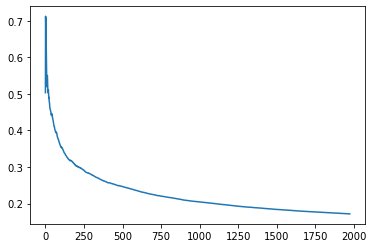

0.171818685555194

In [13]:
from matplotlib import pyplot as plt
plt.plot([i for i in range(len(EpochLoss))],
         [EpochLoss[i]/(i+1) for i in range(len(EpochLoss))])
plt.show()
EpochLoss[-1]/len(EpochLoss)

In [14]:
plt.close('all')

In [34]:
# torch.save(model.state_dict(), r'.\weights\NGNA20211027.pkl')

In [35]:
%%time
# Around 8min 50s
# Test Model (No Data Augmentation)
model.load_state_dict(torch.load(r'.\weights\NGNA20211027.pkl'))
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
pred = []
true = []
imgpaths=[]
#Fe = []
sftmax=nn.Softmax(dim=0)
ProbN=[]
ProbA=[]
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels, imgpath in AFtest_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs,fe = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred.append(predicted.data.cpu().numpy()[0])
        true.append(labels.data.cpu().numpy()[0])
        #Fe.append(fe.data.cpu().numpy())
        ProbN.append(sftmax(outputs[0]).data.cpu().numpy()[0])
        ProbA.append(sftmax(outputs[0]).data.cpu().numpy()[1])
        
        imgpaths.append([imgpath[0],
                         predicted.data.cpu().numpy()[0],
                         labels.data.cpu().numpy()[0],
                         predicted.data.cpu().numpy()[0],
                         sftmax(outputs[0]).data.cpu().numpy()[0],
                         sftmax(outputs[0]).data.cpu().numpy()[1]]
                       )

print('Accuracy of the model on the Test images: {} %'.format(100 * correct / total))
print(confusion_matrix(true, pred))
print(classification_report(true, pred))

Accuracy of the model on the Test images: 95.81254454739843 %
[[4713   73]
 [ 162  664]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4786
           1       0.90      0.80      0.85       826

    accuracy                           0.96      5612
   macro avg       0.93      0.89      0.91      5612
weighted avg       0.96      0.96      0.96      5612

Wall time: 1min 12s


In [36]:
%%time
#1. vote Equally 
df = pd.DataFrame({"Record":[x[0].split('_')[-2] for x in imgpaths],
              "Prediction":[x[1] for x in imgpaths],
              "Label":[x[2] for x in imgpaths]},columns=['Record','Prediction','Label'])
print(df.Label.value_counts())

from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
vp=df.groupby(["Record"])['Prediction'].apply(lambda x: Counter(x).most_common(1)[0][0])
vt=df.groupby('Record')['Label'].apply(lambda x: Counter(x).most_common(1)[0][0])
print(vt.value_counts())

print(confusion_matrix(vt,vp))
print(classification_report(vt,vp))
print(np.sum(vt==vp)/len(vt))

0    4786
1     826
Name: Label, dtype: int64
0    498
1     81
Name: Label, dtype: int64
[[495   3]
 [ 13  68]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       498
           1       0.96      0.84      0.89        81

    accuracy                           0.97       579
   macro avg       0.97      0.92      0.94       579
weighted avg       0.97      0.97      0.97       579

0.9723661485319517
Wall time: 65.5 ms


In [37]:
%%time
#2. Softmax and vote
df2=pd.DataFrame({"Record":[x[0].split('_')[-2] for x in imgpaths],
                 "Label":[x[1] for x in imgpaths],
                 "N":[x[4] for x in imgpaths],
                 "A":[x[5] for x in imgpaths]
                 },columns=['Record','Label','N','A'])
# If Restart and Run all, 
AFLabel = {'N': 0,
           'A': 1,
           'O': 2,
           '~': 3}
dfe = df2.groupby(["Record"])[["N","A"]].sum()
vpe = dfe.apply(lambda x: x.idxmax(),axis=1)
vp2 = vpe.apply(lambda x: AFLabel.__getitem__(x))
vt2 = df.groupby(["Record"])["Label"].mean()
print(confusion_matrix(vt2,vp2))
print(classification_report(vt2,vp2))
print(np.sum(vt2==vp2)/len(vt2))

[[496   2]
 [ 13  68]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       498
           1       0.97      0.84      0.90        81

    accuracy                           0.97       579
   macro avg       0.97      0.92      0.94       579
weighted avg       0.97      0.97      0.97       579

0.9740932642487047
Wall time: 33.9 ms
